In [4]:
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.ndimage import rotate
import tensorflow_addons as tfa

# Speech Denoising Using Deep Learning

In [2]:
s, sr=librosa.load('data 1.06.31 PM/train_clean_male.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)
sn, sr=librosa.load('data 1.06.31 PM/train_dirty_male.wav', sr=None)
X=librosa.stft(sn, n_fft=1024, hop_length=512)

s_valid, sr=librosa.load('data 1.06.31 PM/test_s_01.wav', sr=None)
S_valid_cmplx=librosa.stft(s_valid, n_fft=1024, hop_length=512)
sn_valid, sr=librosa.load('data 1.06.31 PM/test_x_01.wav', sr=None)
X_valid_cmplx=librosa.stft(sn_valid, n_fft=1024, hop_length=512)

In [3]:
X_train = np.abs(X)
Y_train = np.abs(S)
X_valid = np.abs(X_valid_cmplx)
Y_valid = np.abs(S_valid_cmplx)

In [ ]:
class SNRCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_valid, s_valid, X_valid_cmplx):
        self.X_valid = X_valid
        self.s_valid = s_valid
        self.X_valid_cmplx = X_valid_cmplx
        self.best_snr = -float('inf')
        self.snrs = []

    def on_epoch_end(self, epoch, logs=None):
        S_hat_abs_T = self.model.predict(self.X_valid.T)
        S_hat_abs = S_hat_abs_T.T
        S_hat = (self.X_valid_cmplx/self.X_valid) * S_hat_abs
        s_hat = librosa.istft(S_hat, win_length=1024, hop_length=512)
        s_valid = self.s_valid[0:len(s_hat)]
        num = np.sum(np.square(self.s_valid))
        den = np.sum(np.square(s_valid - s_hat))
        snr = 10 * np.log(num / den)

        self.snrs.append(snr)  # Append SNR value for this epoch

        print(f'Epoch {epoch + 1} - Validation SNR: {snr} dB')



In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=20,
    restore_best_weights=True
)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(513,)),
    tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.5), kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.5), kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.5), kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(513, activation='softplus', kernel_initializer='glorot_uniform'),
])

X_train_T = X_train.T  # Transpose X_train to (2459, 513)
Y_train_T = Y_train.T
X_valid_T = X_valid.T
Y_valid_T = Y_valid.T

snr_callback = SNRCallback(X_valid, s_valid, X_valid_cmplx)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

BATCH_SIZE = 32
EPOCHS = 600
Accuracy = model.fit(X_train_T, Y_train_T,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     callbacks=[snr_callback, early_stopping],
                     validation_data=(X_valid_T, Y_valid_T)
                     )

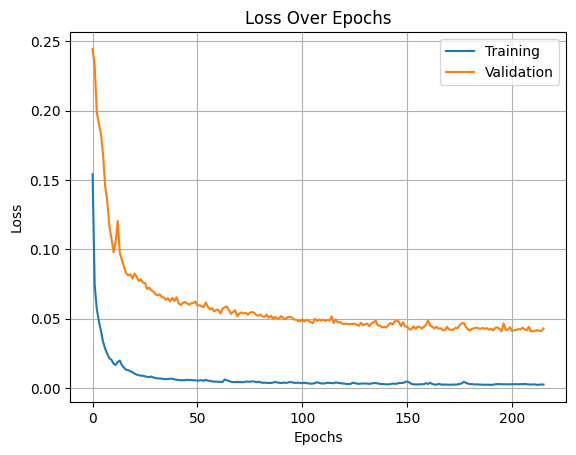

In [ ]:
# Plot of the validation accuracy over epochs
plt.figure()
plt.plot(Accuracy.history['loss'], label='Training')
plt.plot(Accuracy.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

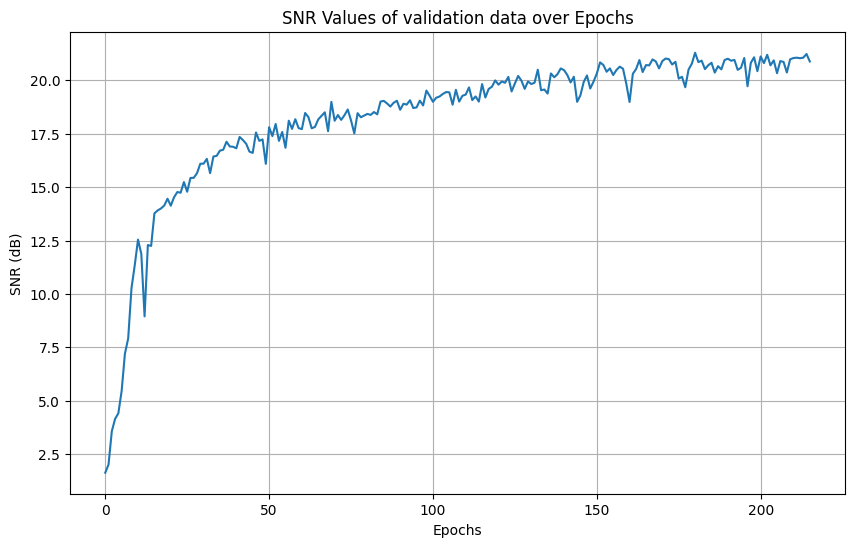

In [ ]:
snr_values = snr_callback.snrs

# Plot SNR values
plt.figure(figsize=(10, 6))
plt.plot(snr_values, linestyle='-')
plt.title('SNR Values of validation data over Epochs')
plt.xlabel('Epochs')
plt.ylabel('SNR (dB)')
plt.grid(True)
plt.show()

In [ ]:
S_hat_abs_T = model.predict(X_valid_T)
S_hat_abs = S_hat_abs_T.T
S_hat = (X_valid_cmplx/X_valid) * S_hat_abs

In [ ]:
print("Noisy Audio Signal")
display(Audio(data=sn_valid, rate=sr))

print("Original Clean Audio Signal")
display(Audio(data=s_valid, rate=sr))

s_hat = librosa.istft(S_hat, win_length=1024, hop_length=512)
print("Reconstructed Clean Audio Signal")
display(Audio(data=s_hat, rate=sr))

Noisy Audio Signal


Original Clean Audio Signal


Reconstructed Clean Audio Signal


In [ ]:
s_valid = s_valid[0:len(s_hat)]
num = np.sum(np.square(s_valid))
den = np.sum(np.square(s_valid - s_hat))
SNR = 10 * np.log(num / den)
print('The SNR value on the validation data is', SNR)

The SNR value on the validation data is 21.045024394989014


In [ ]:
x_test, sr=librosa.load('data 1.06.31 PM/test_x_02.wav', sr=None)
X_test_cmplx=librosa.stft(x_test, n_fft=1024, hop_length=512)
X_test = np.abs(X_test_cmplx)

S_test_hat_abs_T = model.predict(X_test.T)
S_test_hat_abs = S_test_hat_abs_T.T
S_test_hat = (X_test_cmplx/X_test) * S_test_hat_abs

12/12 [==============================] - 0s 686us/step


In [ ]:
print("Noisy Audio Signal")
display(Audio(data=x_test, rate=sr))

s_test_hat = librosa.istft(S_test_hat, win_length=1024, hop_length=512)
print("Reconstructed Clean Audio Signal")
display(Audio(data=s_test_hat, rate=sr))

Noisy Audio Signal


Reconstructed Clean Audio Signal


# Speech Denoising Using 1D CNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(513, 1), strides=2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', strides=2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.3), kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.3), kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(513, activation='softplus')
])

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

BATCH_SIZE = 32
EPOCHS = 200
Accuracy = model.fit(X_train.T, Y_train.T,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(X_valid.T, Y_valid.T)
                     )


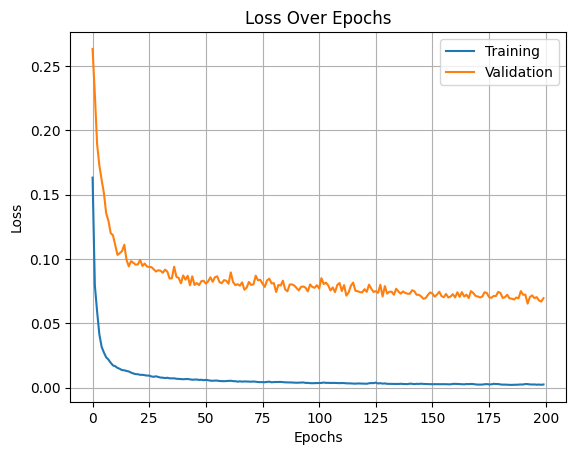

In [8]:
# Plot of the validation accuracy over epochs
plt.figure()
plt.plot(Accuracy.history['loss'], label='Training')
plt.plot(Accuracy.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

In [ ]:
S_hat_abs_T = model.predict(X_valid_T)
S_hat_abs = S_hat_abs_T.T
S_hat = (X_valid_cmplx/X_valid) * S_hat_abs

5/5 [==============================] - 0s 1ms/step


In [ ]:
s_valid = s_valid[0:len(s_hat)]
num = np.sum(np.square(s_valid))
den = np.sum(np.square(s_valid - s_hat))
SNR = 10 * np.log(num / den)
print('The SNR value on the validation data is', SNR)

The SNR value on the validation data is 18.195557594299316


In [ ]:
print("Noisy Audio Signal")
display(Audio(data=sn_valid, rate=sr))

print("Original Clean Audio Signal")
display(Audio(data=s_valid, rate=sr))

s_hat = librosa.istft(S_hat, win_length=1024, hop_length=512)
print("Reconstructed Clean Audio Signal")
display(Audio(data=s_hat, rate=sr))

Noisy Audio Signal


Original Clean Audio Signal


Reconstructed Clean Audio Signal


In [ ]:
S_test_hat_abs_T = model.predict(X_test.T)
S_test_hat_abs = S_test_hat_abs_T.T
S_test_hat = (X_test_cmplx/X_test) * S_test_hat_abs

print("Noisy Audio Signal")
display(Audio(data=x_test, rate=sr))

s_test_hat = librosa.istft(S_test_hat, win_length=1024, hop_length=512)
print("Reconstructed Clean Audio Signal")
display(Audio(data=s_test_hat, rate=sr))

12/12 [==============================] - 0s 1ms/step
Noisy Audio Signal


Reconstructed Clean Audio Signal


# Data Augmentation

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

num_valid = 5000

X_valid = X_train[:num_valid]
Y_valid = Y_train[:num_valid]
X_train = X_train[num_valid:]
Y_train = Y_train[num_valid:]

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1.0/127.5, offset=-1.0, input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(10, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(10, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Accuracy = model.fit(X_train, Y_train,
                     epochs=200,
                     validation_data=(X_valid, Y_valid)
                     )

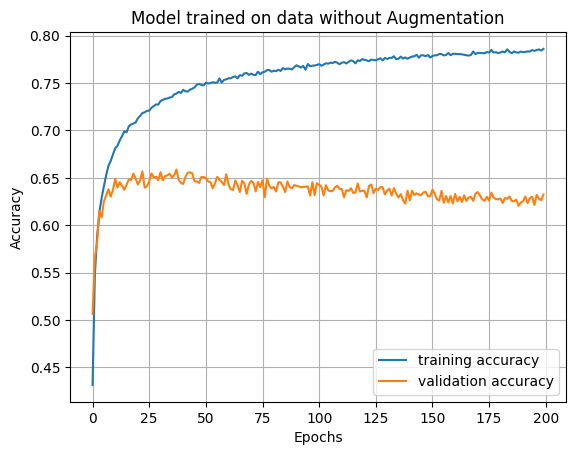

In [ ]:
# Plot of the validation accuracy over epochs
plt.figure()
plt.plot(Accuracy.history['accuracy'], label='training accuracy')
plt.plot(Accuracy.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.title('Model trained on data without Augmentation')
plt.legend()
plt.show()

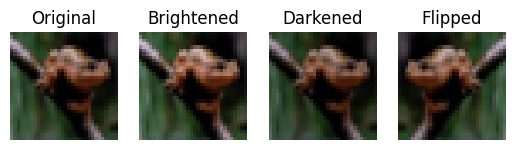

In [ ]:
Aug_data_1 = np.minimum(1.1 * X_train/255, 1.0) # Augmented Dataset 1
Aug_data_2 = 0.9 * X_train/255                  # Augmented Dataset 2
Aug_data_3 = np.flip(X_train/255, axis=2)       # Augmented Dataset 3

image = 0

plt.figure()
plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(X_train[image])
plt.axis('off')

# Brightened Image
plt.subplot(1, 4, 2)
plt.title("Brightened")
plt.imshow(Aug_data_1[image])
plt.axis('off')

# Darkened Image
plt.subplot(1, 4, 3)
plt.title("Darkened")
plt.imshow(Aug_data_2[image])
plt.axis('off')

# Horizontal flipped Image
plt.subplot(1, 4, 4)
plt.title("Flipped")
plt.imshow(Aug_data_3[image])
plt.axis('off')

plt.show()

In [ ]:
Aug_X_train = np.concatenate([Aug_data_1, Aug_data_2, Aug_data_3, X_train/255], axis=0)
Aug_X_train = Aug_X_train * 255
Aug_Y_train = np.concatenate([Y_train] * 4, axis=0)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1.0/127.5, offset=-1.0, input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(10, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(10, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(10, activation='softmax')
])

learning_rate=0.001 # Working better
# learning_rate=0.003

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# BATCH_SIZE = 32
BATCH_SIZE = 200

Accuracy_1 = model.fit(Aug_X_train, Aug_Y_train,
                     epochs=200,
                     batch_size = BATCH_SIZE,
                     validation_data=(X_valid, Y_valid)
                     )

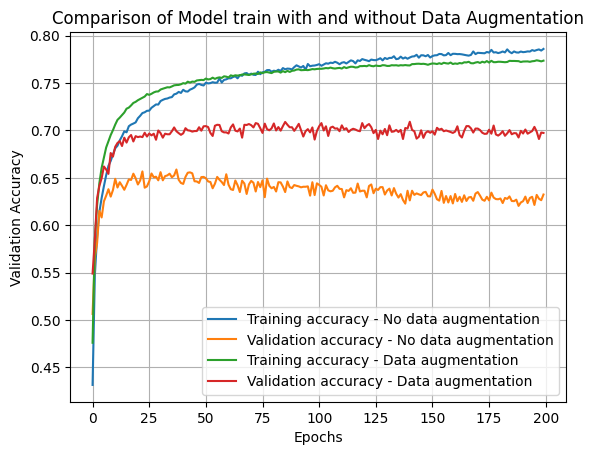

In [ ]:
# Plot of the validation accuracy over epochs
plt.figure()
plt.plot(Accuracy.history['accuracy'], label='Training accuracy - No data augmentation')
plt.plot(Accuracy.history['val_accuracy'], label='Validation accuracy - No data augmentation')
plt.plot(Accuracy_1.history['accuracy'], label='Training accuracy - Data augmentation')
plt.plot(Accuracy_1.history['val_accuracy'], label='Validation accuracy - Data augmentation')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.title('Comparison of Model train with and without Data Augmentation')
plt.legend()
plt.show()

# Self-Supervised Learning via Pretext Tasks 

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

## The Baseline

In [ ]:
X_train_A = []
Y_train_A = []
X_train_B = []
Y_train_B = []

counter = np.zeros((10, 1))

for image, label in zip(X_train, Y_train):
    if counter[label] < 50:
        X_train_A.append(image)
        Y_train_A.append(label)
        counter[label] += 1
    else:
        X_train_B.append(image)
        Y_train_B.append(label)

X_train_A = np.array(X_train_A)
Y_train_A = np.array(Y_train_A)
X_train_B = np.array(X_train_B)
Y_train_B = np.array(Y_train_B)

In [ ]:
class ValidationCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, interval=100):
        super(ValidationCallback, self).__init__()
        self.validation_data = validation_data
        self.interval = interval
        self.loss = []
        self.accu = []

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            val_loss, val_accuracy = self.model.evaluate(self.validation_data[0], self.validation_data[1], verbose=0)
            self.loss.append(val_loss)
            self.accu.append(val_accuracy)
            print(f'Validation loss at epoch {epoch}: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}')


In [ ]:
model_base = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1.0/127.5, offset=-1.0, input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(10, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(10, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model_base.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
EPOCHS = 10000
validation_callback = ValidationCallback((X_test, Y_test), interval=100)
Accuracy_baseline = model_base.fit(X_train_A, Y_train_A,
                     epochs=EPOCHS,
                     batch_size=len(X_train_A),
                     callbacks=[validation_callback]
                     )

In [ ]:
test_loss = validation_callback.loss
test_accu = validation_callback.accu

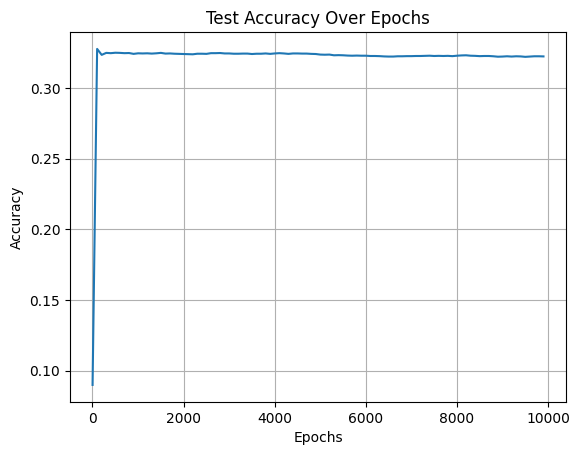

In [ ]:
plt.figure()
x = np.arange(1, EPOCHS+1)
plt.plot(x[1::100], test_accu, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
# plt.legend()
plt.title('Test Accuracy Over Epochs')
plt.show()

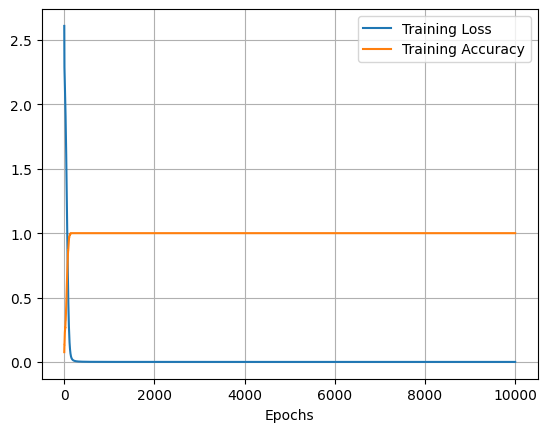

In [ ]:
plt.figure()
plt.plot(Accuracy_baseline.history['loss'], label='Training Loss')
plt.plot(Accuracy_baseline.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)

At a learning rate of 0.001, the impact of dropout may not be readily discernible since training accuracy quickly converges. To enhance the clarity of the dropout's influence, I reduced the learning rate to 0.0001. This adjustment allowed the training accuracy to reach 1 after 1000 epochs, making the dropout effect more evident in the resulting figure.

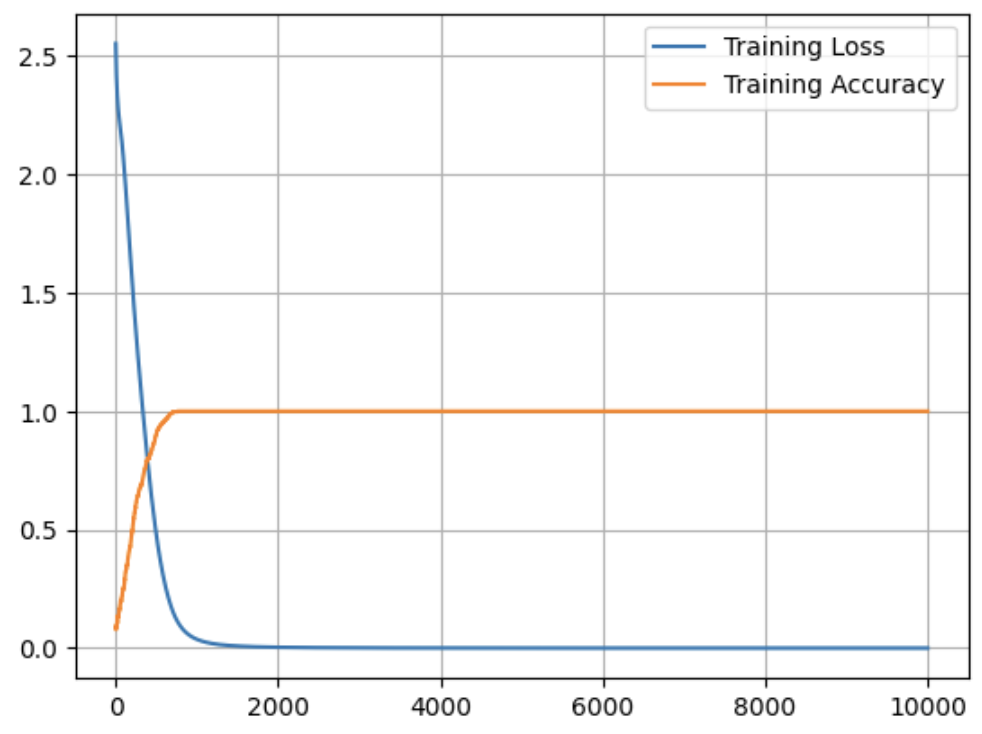

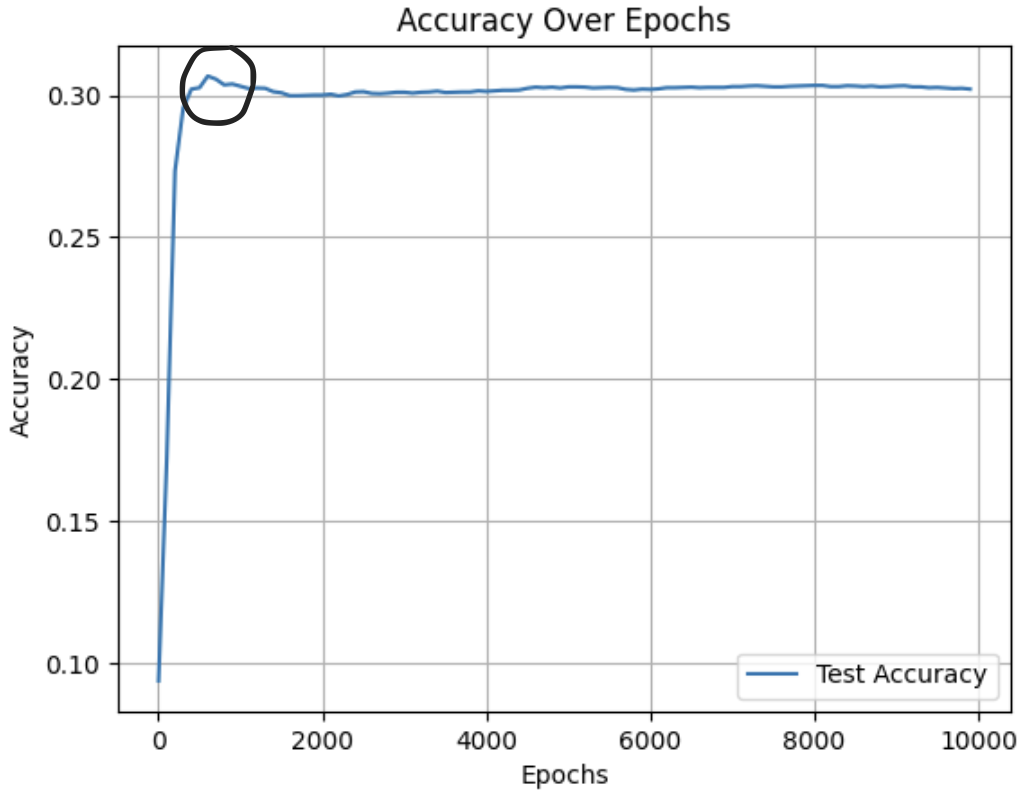

## Pretext task

In [ ]:
class_1 = np.flip(X_train_B, axis=1)
class_2 = rotate(X_train_B, 90, axes=(1, 2), reshape=False)

In [ ]:
Aug_X_train = np.concatenate([X_train_B, class_1, class_2], axis=0)
Y_train_0 = np.zeros(49500, dtype=int)
Y_train_1 = np.ones(49500, dtype=int)
Y_train_2 = 2 * np.ones(49500, dtype=int)
Aug_Y_train = np.concatenate([Y_train_0, Y_train_1, Y_train_2], axis=0)

(-0.5, 31.5, 31.5, -0.5)

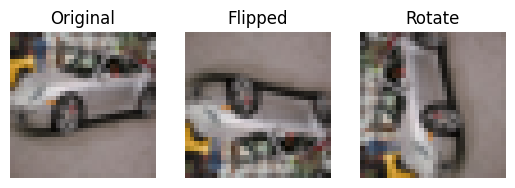

In [ ]:
image = 11

plt.figure()
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(X_train_B[image])
plt.axis('off')

# Brightened Image
plt.subplot(1, 3, 2)
plt.title("Flipped")
plt.imshow(class_1[image])
plt.axis('off')

# Darkened Image
plt.subplot(1, 3, 3)
plt.title("Rotate")
plt.imshow(class_2[image])
plt.axis('off')


In [ ]:
model_pretext = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1.0/127.5, offset=-1.0, input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(10, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(10, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(3, activation='softmax')
])
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model_pretext.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
Accuracy = model_pretext.fit(Aug_X_train, Aug_Y_train,
                     epochs=100,
                     batch_size=100
                     )

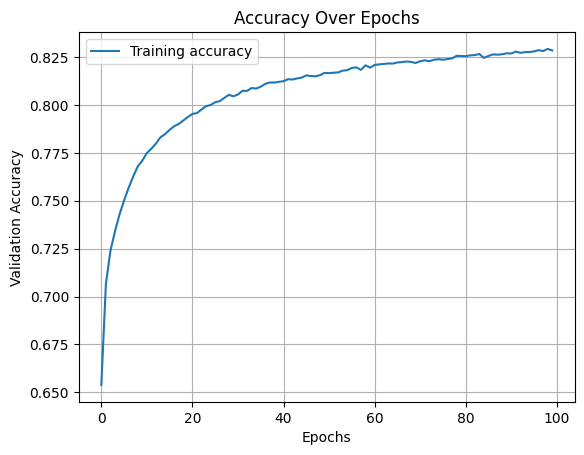

In [ ]:
# Plot of the validation accuracy over epochs
plt.figure()
plt.plot(Accuracy.history['accuracy'], label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
model.save_weights('model_weights.h5')

## Transfer learning task

In [ ]:
model_TL = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1.0/127.5, offset=-1.0, input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(10, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(10, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(10, activation='softmax')
])


In [ ]:
model.load_weights('model_weights.h5')
for layer1, layer2 in zip(model_pretext.layers[:-1], model_TL.layers[:-1]):
    layer2.set_weights(layer1.get_weights())

In [ ]:
optimizers = [
    tf.keras.optimizers.legacy.Adam(learning_rate=0.000001),
    tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
]

optimizers_and_layers = [(optimizers[0], model_TL.layers[0:6]), (optimizers[1], model_TL.layers[7:])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

model_TL.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 10000
validation_callback = ValidationCallback((X_test, Y_test), interval=100)
Accuracy = model_TL.fit(X_train_A, Y_train_A,
                     epochs=EPOCHS,
                     batch_size=len(X_train_A),
                     callbacks=[validation_callback]
                     )

In [ ]:
test_loss_TL = validation_callback.loss
test_accu_TL = validation_callback.accu

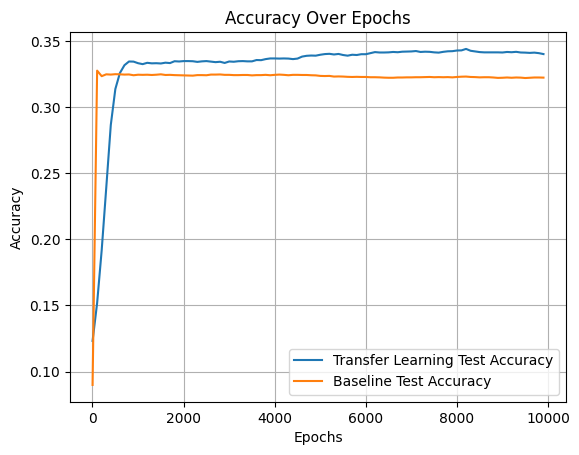

In [ ]:
plt.figure()
x = np.arange(1, EPOCHS+1)
plt.plot(x[1::100], test_accu_TL, label='Transfer Learning Test Accuracy')
plt.plot(x[1::100], test_accu, label='Baseline Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

The model's overall accuracy remains relatively low even with the application of transfer learning. I attribute this primarily to the limited size of the training dataset, which has had a noticeable impact on the model's efficiency.